In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
from torchvision.datasets import ImageFolder, MNIST
from torch.autograd import Variable
from torchvision.utils import make_grid
from torchvision import transforms
from torch import autograd



In [ ]:
batch_size = 64
this_transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5])
])
data_loader = torch.utils.data.DataLoader(MNIST('data', download = "True", train = 'True', transform = this_transform), batch_size=batch_size, shuffle = True)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [ ]:

from matplotlib.widgets import Line2D
from torch.nn.modules.activation import LeakyReLU
class Generator(nn.Module):
  def __init__(self):
    super().__init__()
    self.label_embedding_layer = nn.Embedding(10,16)

    self.net = nn.Sequential(
        nn.Linear(144,128),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Linear(128,256),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Linear(256,512),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Linear(512,1024),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Linear(1024, 784),
        nn.Tanh()
    )

  def forward(self, x, label):
    embedded_label = self.label_embedding_layer(label)
    inp = torch.cat([x,embedded_label], 1)
    out = self.net(inp)
    return out.view(out.size(0), 28, 28)

  


class Discriminator(nn.Module):
  def __init__(self):
    super().__init__()

    self.label_embedding_layer = nn.Embedding(10,16)

    self.net = nn.Sequential(
        nn.Linear(800,1024),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(1024,512),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(512,256),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(256,128),
        nn.LeakyReLU(0.1, inplace=True),
        nn.Dropout(0.3),
        nn.Linear(128,1),
        nn.Sigmoid()
    )

  def forward(self, x, label):
    #print(x.shape, label.shape)
    x = x.view(x.size(0), 784)
    #print(x.shape, label.shape)
    embedded_label  = self.label_embedding_layer(label)
    inp = torch.cat([x, embedded_label], axis = 1)
    out = self.net(inp)
    return out.squeeze()


In [ ]:
def steps_G(batch_size, net_G, net_D, optimizer_G, criteria):
  optimizer_G.zero_grad()

  # Noisy input for generator
  noise_ip = Variable(torch.randn(batch_size, 128)).cuda()
  fake_label = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
  fake_image = net_G(noise_ip, fake_label)
  fake_pred = net_D(fake_image, fake_label)
  loss_G = criteria(fake_pred, Variable(torch.ones(batch_size)).cuda())  # Comparing against 1. Because these should be true labels
  loss_G.backward()
  optimizer_G.step()
  return loss_G.item()


def step_D(batch_size, net_G, net_D, optimizer_D, criteria, real_image, real_label):

  #Step 1: With REAL Image
  real_pred = net_D(real_image, real_label)
  
  real_loss = criteria(real_pred,Variable(torch.ones(batch_size)).cuda()).cuda()

  #Step 2: With fake Image
  noise_ip = Variable(torch.randn(batch_size, 128)).cuda()
  fake_label = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
  
  fake_image = net_G(noise_ip, fake_label)
  
  #print(fake_image.shape, fake_label.shape)
  fake_pred = net_D(fake_image, fake_label)
  #print("here")
  fake_loss = criteria(fake_pred,Variable(torch.zeros(batch_size)).cuda()).cuda()

  loss_D = real_loss + fake_loss
  loss_D.backward()
  optimizer_D.step()
  return loss_D.item()


In [ ]:
!pip install tensorboardX 
from tensorboardX import SummaryWriter
criteria = nn.BCELoss()
net_G = Generator().cuda()
net_D = Discriminator().cuda()
optimizer_G = torch.optim.AdamW(net_G.parameters(), lr = 0.01)
optimizer_D = torch.optim.AdamW(net_D.parameters(), lr = 0.001)

epochs = 5
display_epoch = 5
critics = 5
writer = SummaryWriter()

for epoch in range(epochs):
  print("Running epoch no: {}".format(epoch))

  for idx, (image, label) in enumerate(data_loader):
    real_image = Variable(image).cuda()
    label = Variable(label).cuda()
    net_G.train()
    #print("shape {}".format(real_image.shape))
    d_loss = 0
    for _ in range(critics):
      d_loss += step_D(real_image.shape[0], net_G, net_D, optimizer_D, criteria, real_image, label)

    g_loss = steps_G(real_image.shape[0], net_G, net_D, optimizer_G, criteria)
    writer.add_scalars('scalars', {'g_loss': g_loss, 'd_loss': (d_loss / critics)}, epoch)

    if epoch % display_epoch == 0:
            print(" Generator Loss: {}   Discriminator Loss: {}".format(g_loss, d_loss))
            net_G.eval()
            z = Variable(torch.randn(9, 128)).cuda()
            labels = Variable(torch.LongTensor(np.arange(9))).cuda()
            sample_images = net_G(z, labels).unsqueeze(1)
            grid = make_grid(sample_images, nrow=3, normalize=True)
            writer.add_image('sample_image', grid, epoch)

print("Completed")


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Running epoch no: 0
 Generator Loss: 0.7262107133865356   Discriminator Loss: 4.857422232627869
 Generator Loss: 0.0   Discriminator Loss: 497.33721923828125
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generator Loss: 0.0   Discriminator Loss: 500.0
 Generat

In [ ]:
torch.save(net_G.state_dict(), 'generator_state_5000epoch.pt')

In [ ]:

Variable(torch.Tensor([1,2])).cuda()

tensor([1., 2.], device='cuda:0')

In [ ]:
images = net_G(z, labels).unsqueeze(1)

(-0.5, 271.5, 31.5, -0.5)

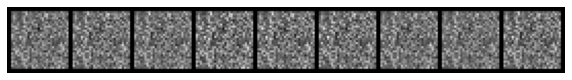

In [ ]:
from torchvision.utils import make_grid
grid = make_grid(images, nrow=10, normalize=True)
fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(grid.permute(1, 2, 0).cpu().data, cmap='binary')
ax.axis('off')